# Few shot pour la classification de signaux 

## Imports et chargement des données

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

TRAIN_PATH = "data/train.hdf5"
ENROLL_PATH = "data/endroll.hdf5"
TEST_PATH= "data/test_fewshot.hdf5"


paths = {
    "train": TRAIN_PATH,
    "enroll":ENROLL_PATH,
    "test":TEST_PATH
}

for name, path in paths.items():
    print(f"\n=== {name.upper()} ===")
    with h5py.File(path, "r") as f:
        print("Clés :", list(f.keys()))


def load_file(path):
    data = h5py.File(path , 'r')
    signals = np.array(data['signaux'])
    snr =  np.array(data['snr'])
    labels_id = np.array(data['labels'])
    return signals, snr, labels_id






=== TRAIN ===
Clés : ['label_name', 'labels', 'signaux', 'snr']

=== ENROLL ===
Clés : ['labels', 'signaux', 'snr']

=== TEST ===
Clés : ['labels', 'signaux', 'snr']


## Dataloaders

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [3]:
class BasicDataset(Dataset):
    def __init__(self, signals, labels, transform=None):
        self.signals = signals
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx]
        y = self.labels[idx]
        
        x = torch.tensor(x, dtype=torch.float32)
        x = x.permute(1,0)  

        return x, torch.tensor(y, dtype=torch.long)



In [4]:
X, _, y = load_file(TRAIN_PATH)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=42
)



In [5]:
print("Shape X :", X_train.shape)
print("Shape y :", y_train.shape)
print("Classes :", np.unique(y_train))


Shape X : (27000, 2048, 2)
Shape y : (27000,)
Classes : [0 1 2 3 4 5]


In [6]:
train_dataset = BasicDataset(X_train, y_train)
val_dataset   = BasicDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Pipeline

### Modèle

In [7]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1   = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2   = nn.BatchNorm1d(out_channels)

        self.skip = None
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.skip is not None:
            identity = self.skip(identity)
        out += identity
        return F.relu(out)


class ResNet1D_SegmentClassifier(nn.Module):
    def __init__(self, n_segments=16, emb_dim=128, n_classes=6):
        super().__init__()

        self.n_segments = n_segments
        self.segment_length = 2048 // n_segments

        # Encodeur de segments
        self.conv1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(4)

        self.block1 = ResidualBlock1D(64, 64)
        self.block2 = ResidualBlock1D(64, 128, stride=2)
        self.block3 = ResidualBlock1D(128, emb_dim)

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(emb_dim, n_classes)

    def encode_segment(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x).squeeze(-1)
        return F.normalize(x, p=2, dim=1)  

    def forward(self, x):
        B = x.size(0)
        embeddings = []

        for i in range(self.n_segments):
            start = i * self.segment_length
            end = start + self.segment_length
            seg = x[:, :, start:end]
            z = self.encode_segment(seg)
            embeddings.append(z)

        Z = torch.stack(embeddings, dim=1)

        Z_global = Z.mean(dim=1)  

        logits = self.fc(Z_global) 

        return logits

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

n_segments = 16

model = ResNet1D_SegmentClassifier(n_segments=n_segments)

save_path = f"models/resnet_{n_segments}_segments.pth"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


from tqdm import tqdm

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        
        logits = model(xb)
        loss = criterion(logits, yb)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = train_correct / total
    train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            total_val += yb.size(0)

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"\nEpoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}\n")
    

torch.save(model.state_dict(), save_path)
print(f"Modèle sauvegardé dans {save_path}")




Epoch 1/3 [Train]:   1%|          | 3/422 [00:05<12:07,  1.74s/it]


KeyboardInterrupt: 

### Few shot learning

In [9]:
model = ResNet1D_SegmentClassifier(n_classes=6)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

ResNet1D_SegmentClassifier(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (block1): ResidualBlock1D(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): ResidualBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [10]:
class FewShotEncoder(nn.Module):
    def __init__(self, classifier):
        super().__init__()
        self.n_segments = classifier.n_segments
        self.segment_length = classifier.segment_length

        self.conv1 = classifier.conv1
        self.bn1   = classifier.bn1
        self.pool1 = classifier.pool1
        self.block1 = classifier.block1
        self.block2 = classifier.block2
        self.block3 = classifier.block3
        self.global_pool = classifier.global_pool

    def encode_segment(self, seg):
        x = self.pool1(F.relu(self.bn1(self.conv1(seg))))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x).squeeze(-1)   
        return F.normalize(x, p=2, dim=1)

    def forward(self, x):
        B, C, L = x.shape
        seg_embs = []

        for i in range(self.n_segments):
            s = i * self.segment_length
            e = s + self.segment_length
            seg = x[:, :, s:e]
            z = self.encode_segment(seg)
            seg_embs.append(z)

        seg_embs = torch.stack(seg_embs, dim=1) 

        z_global = seg_embs.mean(dim=1)          
        z_global = F.normalize(z_global, p=2, dim=1)

        return z_global
    

encoder = FewShotEncoder(model)
encoder.to(device)
encoder.eval()



FewShotEncoder(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (block1): ResidualBlock1D(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): ResidualBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequ

In [11]:
X_few_shot, _, y_few_shot = load_file(ENROLL_PATH)
X_test, _, y_test = load_file(TEST_PATH)

print(y_test)

X_few_shot = torch.tensor(X_few_shot, dtype=torch.float32).permute(0,2,1)  
y_few_shot = torch.tensor(y_few_shot, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32).permute(0,2,1)
y_test = torch.tensor(y_test, dtype=torch.long)


def sample_k_per_class(X, y, k):
    Xk, yk = [], []
    classes = torch.unique(y)

    for c in classes:
        idx = torch.where(y == c)[0]
        chosen = idx[torch.randperm(len(idx))[:k]]
        Xk.append(X[chosen])
        yk.append(y[chosen])

    return torch.cat(Xk), torch.cat(yk)

X_few_shot, y_few_shot = sample_k_per_class(X_few_shot, y_few_shot, k=3)




[11 11  6 11  6  6  8 10  8 10 11  6  7  6  9 10 10  9  7 10 10 10  7 10
 10  7 11  7  6  7  7  8  9 10 11 11 11 10  7  9 10  7  9  8  9  9  9  8
  6 10  7  6  7  9 11 11 11  9  6  9 11  9  6  8  6 10  8  8  7 11  9  8
  8  8 11  8 11  8  6  8  6  6  8 10 10  9 11  9  7 10  7  8  8  8  7  6
  9 10  8 10  9  9  9 11  9 11  8  8  7  9  9  6  7  8  9  7  7 11  7  6
  7  9  9 11 10  9  9  7  9  8  9  8 11  7  6 10 10  7 11 10  9  8  6  7
  9 11 10  6  6  6  7  6  6 11  9  9  7  6  6 10  6  8 10  9 10 11  8  8
  6  6 11  6  7 10  6  9 11 11  7  8  6  9 10 10 10  9 10  6 10  9  9 11
  7 10  8  6  9  7  7 11  9 11  9  9 10  8 11  6  9  6 10 10 11  8 11  8
  6 11  8  8  8  9  6 10 11  8  8 11 10  9  6 11 11  9  8 11  7  9 11  7
  6  7  9  8 10  7  6  8  6  9  7  9  8  9  6  9  7 10 11 10  6  7 11 11
 11  8 11  9  7  8  8  9  6  6  9  8  7 10  7 11  8  6  9 11  6  7  6 11
 11  6  7 11  8  6 11 11  7  6  6 11  7  6  7 10 11 11  7 10  6  7  6  6
 11 11  8  8  9 10  7  6  9  8 10  9 11 10  6  8 11

In [14]:
def compute_prototypes(encoder, X, y):
    encoder.eval()
    classes = torch.unique(y)
    protos = []
    labels = []

    with torch.no_grad():
        for c in classes:
            Xc = X[y == c].to(device)
            z = encoder(Xc)
            proto = z.mean(dim=0)  
            protos.append(proto)
            labels.append(c)

    return torch.stack(protos), torch.tensor(labels)

prototypes, proto_labels = compute_prototypes(encoder, X_few_shot, y_few_shot)




def classify(encoder, X_test, prototypes, proto_labels):
    encoder.eval()
    preds = []

    with torch.no_grad():
        z = encoder(X_test.to(device))  
        dists = torch.cdist(z, prototypes)  
        pred_idx = dists.argmin(dim=1)
        preds = proto_labels[pred_idx]

    return preds




preds = classify(encoder, X_test, prototypes, proto_labels)
acc = (preds.cpu() == y_test).float().mean()
print("Few-shot accuracy :", acc.item())





Few-shot accuracy : 0.75


## Benchmark

In [15]:
from sklearn.metrics import confusion_matrix

def sample_task(X, y, k_shot=1, n_query=20):
    classes = torch.unique(y)
    X_support, y_support = [], []
    X_query, y_query = [], []

    for c in classes:
        idx = torch.where(y == c)[0]
        perm = idx[torch.randperm(len(idx))]

        support_idx = perm[:k_shot]
        query_idx   = perm[k_shot:k_shot + n_query]

        X_support.append(X[support_idx])
        y_support.append(y[support_idx])

        X_query.append(X[query_idx])
        y_query.append(y[query_idx])

    return (
        torch.cat(X_support),
        torch.cat(y_support),
        torch.cat(X_query),
        torch.cat(y_query)
    )


def benchmark_few_shot(encoder, X, y, n_tasks=1000, k_shot=1, n_query=20):
    
    all_preds = []
    all_true  = []
    accs = []

    for t in range(n_tasks):
        
        Xs, ys, Xq, yq = sample_task(X, y, k_shot=k_shot, n_query=n_query)

        prototypes, proto_labels = compute_prototypes(encoder, Xs, ys)
        preds = classify(encoder, Xq, prototypes, proto_labels)

        acc = (preds.cpu() == yq.cpu()).float().mean().item()
        accs.append(acc)

        all_preds.append(preds.cpu())
        all_true.append(yq.cpu())

        if (t+1) % 50 == 0:
            print(f"[{t+1}/{n_tasks}]  mean acc = {np.mean(accs):.3f}")

    all_preds = torch.cat(all_preds)
    all_true = torch.cat(all_true)

    cm = confusion_matrix(all_true.numpy(), all_preds.numpy(),
                          labels=torch.unique(y).numpy())
    
    labels = torch.unique(y).cpu().numpy()

    return np.mean(accs), np.std(accs), cm, labels

In [16]:
mean_acc, std_acc, cm, labels = benchmark_few_shot(
    encoder,
    X_test,    
    y_test,
    n_tasks=1000,
    k_shot=1,
    n_query=20
)

print("Mean accuracy :", mean_acc)
print("Std:", std_acc)
print("Confusion matrix shape:", cm.shape)


[50/1000]  mean acc = 0.691
[100/1000]  mean acc = 0.690
[150/1000]  mean acc = 0.694
[200/1000]  mean acc = 0.691
[250/1000]  mean acc = 0.694
[300/1000]  mean acc = 0.696
[350/1000]  mean acc = 0.695
[400/1000]  mean acc = 0.695
[450/1000]  mean acc = 0.693
[500/1000]  mean acc = 0.693
[550/1000]  mean acc = 0.693
[600/1000]  mean acc = 0.693
[650/1000]  mean acc = 0.692
[700/1000]  mean acc = 0.692
[750/1000]  mean acc = 0.692
[800/1000]  mean acc = 0.690
[850/1000]  mean acc = 0.691
[900/1000]  mean acc = 0.691
[950/1000]  mean acc = 0.691
[1000/1000]  mean acc = 0.691
Mean accuracy : 0.6908500000834465
Std: 0.0634803100826402
Confusion matrix shape: (6, 6)


## Résultats

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

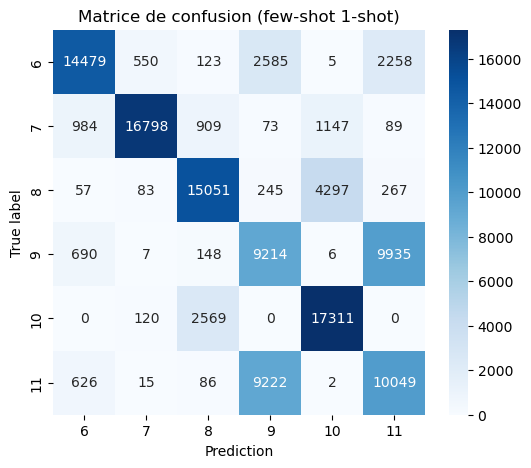

In [18]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)

plt.ylabel("True label")
plt.xlabel("Prediction")
plt.title("Matrice de confusion (few-shot 1-shot)")
plt.show()




### Tsne

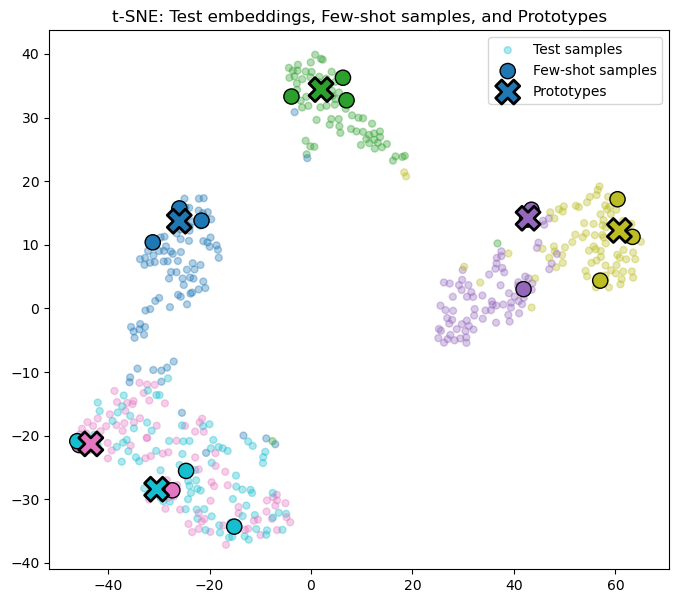

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

encoder.eval()

with torch.no_grad():
    Z_test = encoder(X_test.to(device)).cpu()       
    Z_few  = encoder(X_few_shot.to(device)).cpu()   
    Z_proto = prototypes.cpu()                      

Z_all = torch.cat([Z_test, Z_few, Z_proto], dim=0)  

labels_all = torch.cat([
    y_test.cpu(),            
    y_few_shot.cpu(),        
    proto_labels.cpu()       
])


point_type = torch.cat([
    torch.zeros(len(Z_test)),          
    torch.ones(len(Z_few)),            
    torch.ones(len(Z_proto)) * 2       
])

tsne = TSNE(
    n_components=2,
    perplexity=20,
    learning_rate=200,
    n_iter=2000,
    init="pca"
)

Z_2D = tsne.fit_transform(Z_all.numpy())


plt.figure(figsize=(8, 7))


mask_test = (point_type == 0)
plt.scatter(
    Z_2D[mask_test, 0], Z_2D[mask_test, 1],
    c=labels_all[mask_test], cmap="tab10",
    alpha=0.35, s=25,
    label="Test samples"
)


mask_few = (point_type == 1)
plt.scatter(
    Z_2D[mask_few, 0], Z_2D[mask_few, 1],
    c=labels_all[mask_few], cmap="tab10",
    edgecolors="black", linewidths=1,
    s=120, marker="o",
    label="Few-shot samples"
)


mask_proto = (point_type == 2)
plt.scatter(
    Z_2D[mask_proto, 0], Z_2D[mask_proto, 1],
    c=labels_all[mask_proto], cmap="tab10",
    marker="X", edgecolors="black",
    linewidths=2, s=300,
    label="Prototypes"
)

plt.title("t-SNE: Test embeddings, Few-shot samples, and Prototypes")
plt.legend()
plt.show()
